In [14]:
import zipfile

zip_path = '/content/kagglecatsanddogs_5340.zip'  # Caminho para o arquivo zip
extract_dir = '/content/dataset/Pet'  # Diretório de extração

# Abrindo e extraindo o arquivo zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Arquivo extraído com sucesso!")


Arquivo extraído com sucesso!


In [15]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_path = '/content/dataset/Pet/PetImages'

# Carregar o dataset
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # Dividir em 80% para treino e 20% para validação
    subset='training',
    seed=123,
    image_size=(150, 150),  # Redimensionar imagens para 150x150
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

print("Dataset carregado com sucesso!")


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Dataset carregado com sucesso!


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Construir o modelo
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),  # Normalizar as imagens
    layers.Conv2D(32, 3, activation='relu'),  # Primeira camada convolucional
    layers.MaxPooling2D(),  # Max pooling
    layers.Conv2D(64, 3, activation='relu'),  # Segunda camada convolucional
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),  # Terceira camada convolucional
    layers.MaxPooling2D(),
    layers.Flatten(),  # Achatar a saída das camadas convolucionais
    layers.Dense(128, activation='relu'),  # Camada densa
    layers.Dense(1, activation='sigmoid')  # Camada de saída (binária)
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Visualizar o modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
import tensorflow as tf
import os
from PIL import Image, ExifTags

# Caminho para as imagens
data_dir = '/content/dataset/Pet/PetImages'

# Função para verificar se uma imagem é válida
def is_valid_image(file_path):
    try:
        # Tentar abrir a imagem
        img = Image.open(file_path)
        img.verify()  # Verificar integridade

        # Reabrir para acessar os metadados
        img = Image.open(file_path)
        exif_data = img._getexif()  # Obter metadados EXIF
        if exif_data:
            # Verificar a presença de uma chave importante nos metadados, como orientação
            orientation_key = next((key for key, val in ExifTags.TAGS.items() if val == 'Orientation'), None)
            if orientation_key and orientation_key not in exif_data:
                return False  # Metadados inconsistentes
        return True
    except (IOError, SyntaxError, AttributeError):
        return False

# Remover imagens corrompidas ou inválidas
for class_name in ["Dog", "Cat"]:
    class_dir = os.path.join(data_dir, class_name)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        if not is_valid_image(file_path):
            print(f"Removendo imagem inválida: {file_path}")
            os.remove(file_path)  # Remove o arquivo inválido

# Carregar o conjunto de dados
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=32
)

# Otimizar desempenho do carregamento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Treinar o modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/5435.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/10764.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/4607.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/9643.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/8508.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/5530.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/10107.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/1999.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/11549.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/2877.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/5955.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/3837.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/444.jpg
Removendo imagem inválida: /content/dataset/Pet/PetImages/Dog/9188.jpg
Remo

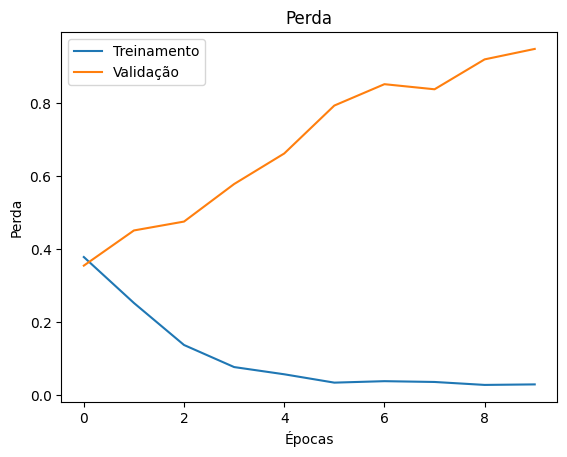

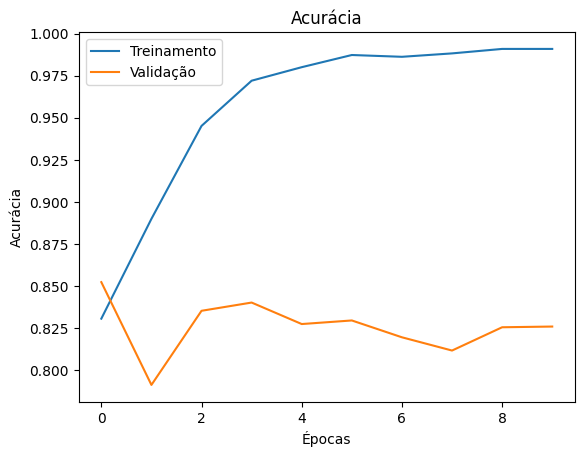

In [51]:
import matplotlib.pyplot as plt

# Perda
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


In [52]:
results = model.evaluate(val_ds)
print(f"Perda no conjunto de validação: {results[0]:.4f}")
print(f"Acurácia no conjunto de validação: {results[1]:.4f}")


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8430 - loss: 0.8250
Perda no conjunto de validação: 0.9475
Acurácia no conjunto de validação: 0.8260


In [54]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    prediction = tf.sigmoid(prediction)  # Garantir que o valor esteja entre 0 e 1
    print(f"Predição: {'Dog' if prediction[0][0] > 0.5 else 'Cat'}")
    print(f"Probabilidade: {prediction[0][0]:.4f}")


predict_image('/content/cat.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predição: Cat
Probabilidade: 0.0007
